# QUIMB extract phases
Created 03/07/2024

Objectives:
* Use QUIMB to extract SPT phase from boundary operators calculated [here](quimb_save_boundary_operators.ipynb).

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [54]:
from itertools import chain, combinations
from collections import defaultdict
import re

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [35]:
import numpy as np
import jax.numpy as jnp

import pandas as pd

import matplotlib.pyplot as plt

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

## Load boundary operators

In [15]:
SOL_DIR = r"solutions/"

In [25]:
file_name_pattern = re.compile(r'^\d\.\d_\d_\d\.pickle$')

In [30]:
def parse_file_name(file_name):
    if not bool(file_name_pattern.match(file_name)):
        return None

    file_name = '.'.join((file_name.split('.'))[:-1])

    b, sym_index, i = file_name.split('_')

    b = float(b)
    sym_index = int(sym_index)
    i = int(i)
    
    return (b, sym_index, i)

In [31]:
boundary_operator_solutions = dict()

for local_file_name in list(os.walk(SOL_DIR))[0][2]:
    f_name = r"{}/{}".format(SOL_DIR, local_file_name, ignore_unknown=False)

    key = parse_file_name(local_file_name)

    if key is not None:
        with open(f_name, 'rb') as f:
            out = pickle.load(f)
    
            boundary_operator_solutions[key] = out

In [32]:
boundary_operator_solutions[(0.0, 1, 1)]

[Array(0.00193806, dtype=float32),
 TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=5)]

In [24]:
boundary_operator_solutions.keys()

dict_keys([])

### Check values

In [33]:
scores = [float(v[0]._value) for v in boundary_operator_solutions.values()]

In [36]:
pd.Series(scores).describe()

count    63.000000
mean      0.402726
std       1.738055
min       0.001184
25%       0.031378
50%       0.051851
75%       0.090049
max       9.978164
dtype: float64

In [39]:
score_pairs = defaultdict(list)

for k, v in boundary_operator_solutions.items():
    score_pairs[k[:-1]].append((k[-1], float(v[0]._value)))

In [40]:
best_score_pairs = {
    k: min(v, key=lambda x: x[1]) for k, v in score_pairs.items()
}

In [41]:
best_scores = [v[1] for v in best_score_pairs.values()]

In [42]:
len(best_score_pairs)

63

In [43]:
pd.Series(best_scores).describe()

count    63.000000
mean      0.402726
std       1.738055
min       0.001184
25%       0.031378
50%       0.051851
75%       0.090049
max       9.978164
dtype: float64

In [44]:
best_boundary_operators = {
    k: boundary_operator_solutions[(*k, v[0])]
    for k, v in best_score_pairs.items()
    if k[1] != 0.5
}

In [45]:
len(best_boundary_operators)

63

# Definitions

In [46]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])

In [47]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [48]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [49]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

In [51]:
def generate_rdm_from_tenpy_psi(mps_psi, symmetry_site_pairs,
    leftmost_symmetry_site, num_symmetry_sites, num_boundary_sites):
    
    psi_arrays = list()
    psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, mps_psi.L-1):
        psi_arrays.append(mps_psi.get_B(i).to_ndarray())
    psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())
    
    q1 = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )
    
    problem_rdm = generate_problem_rdm(
        q1,
        symmetry_site_pairs,
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites
    )

    return problem_rdm

## Optimisation functions

In [96]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo_pair.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo_pair.tag_map['right_mpo']))
    )

    return (ml, mr)

In [97]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=0):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(c_abs_squared+epsilon))

    target = jnp.sqrt(1+epsilon)
    loss = (c_abs - target)**2

    return loss

In [98]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [99]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [100]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [101]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [102]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

## SPT extraction functions

In [103]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [104]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [105]:
e, a, b, c = symmetry_labels

In [106]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [107]:
def tensor_network_to_mpo(tn):
    sites = [
        int(s[1:]) for s in tn.tag_map
        if s[0]=='I'
    ]
    
    rho = qtn.MatrixProductOperator(
        [t.data for t in tn.tensors],
        sites=sites
    )

    return rho

In [108]:
def mpo_hermitian_conjugate(quimb_mpo):
    t = quimb_mpo.copy().conj()
    relabel_mpo(t, 'b', 'k')

    return t

In [109]:
def get_proj_rep_phase(rho, u_g, u_h, u_gh):
    t = (
        rho
        ._apply_mpo(u_h, compress=False, contract=False)
        ._apply_mpo(u_g, compress=False, contract=False)
        ._apply_mpo(mpo_hermitian_conjugate(u_gh), compress=False, contract=False)
    )

    out = t.trace()

    return (out/(np.abs(out)), np.abs(out))

In [110]:
def get_quimb_mps_from_tenpy_mps(tenpy_mps):
    psi_arrays = list()
    psi_arrays.append(tenpy_mps.get_B(0, 'Th')[0, ...].to_ndarray())
    for i in range(1, tenpy_mps.L-1):
        psi_arrays.append(tenpy_mps.get_B(i).to_ndarray())
    psi_arrays.append(tenpy_mps.get_B(tenpy_mps.L-1)[..., 0].to_ndarray())
    
    quimb_mps = (
        qtn
        .tensor_1d
        .MatrixProductState(psi_arrays, shape='lpr')
    )

    return quimb_mps

In [111]:
def get_proj_rep_phases(tenpy_mps, unitaries):
    quimb_mps = get_quimb_mps_from_tenpy_mps(tenpy_mps)
    sites = [
        int(s[1:]) for s in unitaries[0].tag_map
        if s[0]=='I'
    ]
    rho = quimb_mps.partial_trace_to_mpo(sites, rescale_sites=False)
    out = list()

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()
    for a, b, c in group_products:
        phase = get_proj_rep_phase(
            rho,
            unitaries_dict[a],
            unitaries_dict[b],
            unitaries_dict[c]
        )

        out_phases.append(phase)

    return out_phases

# Extract phases

In [112]:
b_params = np.delete(np.round(np.linspace(0, 2, 21), 3), 10)

In [120]:
proj_rep_phases = list()

for t in b_params:
    tenpy_mps = psi_dict[t]

    unitaries = [best_boundary_operators[(t, i)][1] for i in [1,2,3]]

    unitary_pairs = [split_mpo_pair(p) for p in unitaries]
    mpo_pairs = [(tensor_network_to_mpo(x), tensor_network_to_mpo(y)) for x,y in unitary_pairs]
    left_unitaries, right_unitaries = zip(*mpo_pairs)

    left_phases = get_proj_rep_phases(tenpy_mps, left_unitaries)
    right_phases = get_proj_rep_phases(tenpy_mps, right_unitaries)

    proj_rep_phases.append([left_phases, right_phases])

In [124]:
np.round(
    proj_rep_phases[..., ::2, 0]/proj_rep_phases[..., 1::2, 0],
    2
)

array([[[-1.+0.j  , -1.+0.j  , -1.-0.j  ],
        [-1.-0.j  , -1.-0.j  , -1.-0.j  ]],

       [[-1.+0.j  , -1.+0.j  , -1.+0.j  ],
        [-1.+0.j  , -1.-0.j  , -1.+0.j  ]],

       [[-1.+0.j  , -1.-0.j  , -1.-0.j  ],
        [-1.-0.j  , -1.+0.j  , -1.-0.j  ]],

       [[-1.-0.j  , -1.+0.j  , -1.+0.j  ],
        [-1.+0.j  , -1.-0.j  , -1.-0.j  ]],

       [[-1.+0.j  , -1.-0.j  , -1.+0.j  ],
        [-1.+0.01j, -1.-0.j  , -1.+0.01j]],

       [[-1.+0.j  , -1.+0.j  , -1.-0.j  ],
        [-1.+0.j  , -1.-0.j  , -1.-0.j  ]],

       [[-1.+0.j  , -1.-0.01j, -1.+0.01j],
        [-1.+0.01j, -1.+0.j  , -1.+0.02j]],

       [[-1.-0.06j, -1.-0.03j, -1.-0.03j],
        [-1.-0.03j, -1.-0.01j, -1.-0.01j]],

       [[-1.-0.01j, -1.-0.01j, -1.-0.03j],
        [-1.+0.j  , -1.-0.01j, -1.-0.01j]],

       [[-1.-0.07j, -1.+0.j  , -1.-0.06j],
        [-1.+0.02j, -1.-0.j  , -1.+0.03j]],

       [[ 1.+0.01j,  1.+0.j  ,  1.-0.03j],
        [ 1.-0.j  ,  1.+0.01j,  1.-0.01j]],

       [[ 1.+0.j  ,  1.-0.01j,  

In [125]:
gauge_invariant_proj_rep_phase = proj_rep_phases[..., ::2, 0]/proj_rep_phases[..., 1::2, 0]

In [127]:
delta_gauge_invariant_proj_rep_phase = gauge_invariant_proj_rep_phase.copy()
delta_gauge_invariant_proj_rep_phase[:10]*=-1

In [130]:
np.log(1j)

1.5707963267948966j

In [131]:
delta_gauge_invariant_proj_rep_angle = np.imag(np.log(delta_gauge_invariant_proj_rep_phase))

In [134]:
delta_gauge_invariant_proj_rep_angle.shape

(20, 2, 3)

In [143]:
markers = ['>', '<']

In [149]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [150]:
e, a, b, c = symmetry_labels

In [151]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [152]:
side_labels = ['Left', 'Right']

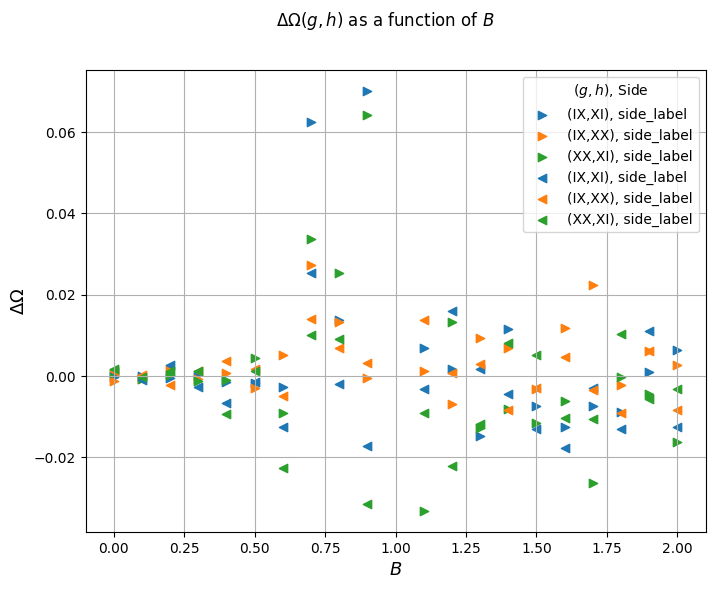

In [164]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (marker, side_label) in enumerate(zip(markers, side_labels)):
    for j, (col, label) in enumerate(zip(colors, symmetry_pair_labels)):
        plt.scatter(
            b_params,
            delta_gauge_invariant_proj_rep_angle[:, i, j],
            marker=marker,
            color=col,
            label = f'({label}), side_label'
        )

ax.grid()
ax.set_ylabel(r'$\Delta \Omega$', fontsize=13)
ax.set_xlabel('$B$', fontsize=13)

ax.legend(loc='upper right', title='$(g,h)$, Side')

fig.suptitle(r'$\Delta \Omega(g,h)$ as a function of $B$')

fig.savefig(r'plots/delta_proj_rep_angle_from_mpo_bosonic.png', dpi=200)